In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
path = '/gdrive/MyDrive/app/'

In [ ]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np

df = pd.read_csv(path + 'data_lesson4.csv', ',')
df.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1
6,9,280.20,1,0,Surburban,1,Phone,Buy One Get One,0
7,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0
8,9,675.07,1,1,Rural,1,Phone,Discount,0
9,10,32.84,0,1,Urban,1,Web,Buy One Get One,0


In [ ]:
%matplotlib inline

from sklearn.model_selection import train_test_split

# Извлечение признаков
df = df.rename(columns={"offer": "treatment", "conversion": "target"})

df.loc[(df['treatment'] != 'No Offer') , 'treatment'] = 1
df.loc[(df['treatment'] == 'No Offer') , 'treatment'] = 0

df.head(6)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
5,6,134.83,0,1,Surburban,0,Phone,1,1


In [ ]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df['recency'].unique().tolist()

[10, 6, 7, 9, 2, 1, 5, 4, 3, 11, 12, 8]

In [ ]:
df['zip_code'].unique().tolist()

['Surburban', 'Rural', 'Urban']

In [ ]:
df['channel'].unique().tolist()

['Phone', 'Web', 'Multichannel']

In [ ]:
list_name = ['zip_code','channel']
for name in list_name:
  df = pd.concat([df, pd.get_dummies(df[name], prefix=name).astype(np.int8)], axis=1)
  df.drop(name, axis=1, inplace=True)

In [ ]:
df.head(2)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1


In [ ]:
df.columns.tolist()

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'is_referral',
 'treatment',
 'target',
 'zip_code_Rural',
 'zip_code_Surburban',
 'zip_code_Urban',
 'channel_Multichannel',
 'channel_Phone',
 'channel_Web']

In [ ]:
df.index

RangeIndex(start=0, stop=64000, step=1)

In [ ]:
indices_train = df.index  # индексы, для которых знаем результат  
#indices_test = df_test.index # индексы, для которых не знаем результат (можем просто дать модели поработать потом)
indices_learn, indices_valid = train_test_split(df.index, test_size=0.3, random_state=123) # разбили известный набор на 2 части

# данные для обучения
list_name = df.columns.to_list()
list_name.remove('target')
list_name.remove('treatment')

X_train = df.loc[indices_learn, list_name] # признаки о клиенте (в них остались только описания клиентов )
y_train = df.loc[indices_learn, 'target'] #целевой признак (те кто сделал правильное действие)
treat_train = df.loc[indices_learn, 'treatment']  #те кому написали смс с предложением
#данные для валидации
X_val = df.loc[indices_valid, list_name]
y_val = df.loc[indices_valid, 'target']
treat_val =  df.loc[indices_valid, 'treatment']
#весь набор целиком
X_train_full = df.loc[indices_train, list_name]
y_train_full = df.loc[:, 'target']
treat_train_full = df.loc[:, 'treatment']
#данные из теста (слепые)
#X_test = df.loc[indices_test, :]
# наш категорийный признак
cat_features = ['channel_Phone']
# словарь для записывания результатов
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [ ]:
from sklearn.utils.validation import check_consistent_length
import matplotlib.pyplot as plt

# замена для родной функции из skuplift
def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

In [ ]:
!pip install scikit-uplift

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 14 kB/s 


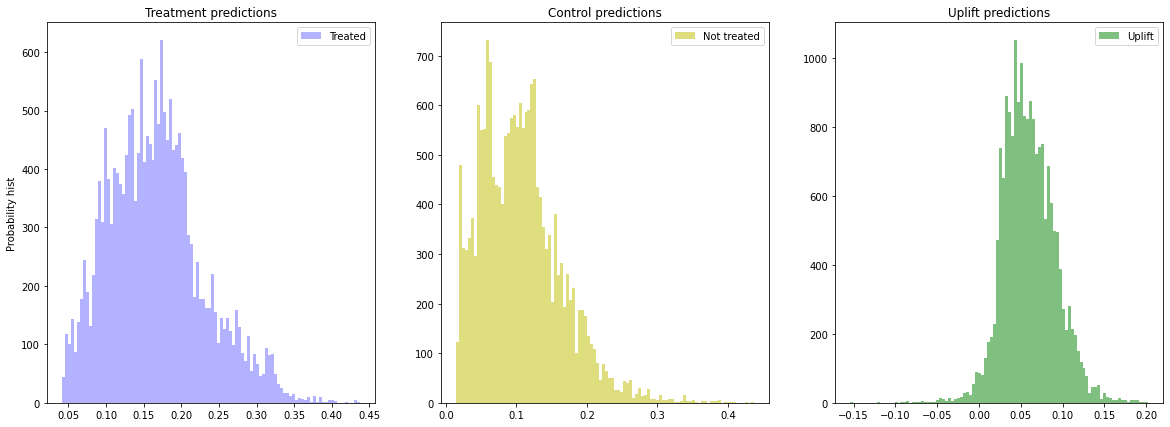

In [ ]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
#from sklift.viz import plot_uplift_preds ## в новой версии проблема (беру свой вариант)
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

N =20000
sm = SoloModel(   CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(   X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

# размер uplift на топ k процентах выборки
sm_score = uplift_at_k( y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score)

sm_score = uplift_at_k( y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['uplift@20%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds_(   sm_trmnt_preds , sm_ctrl_preds, bins=100);#ctrl_preds=

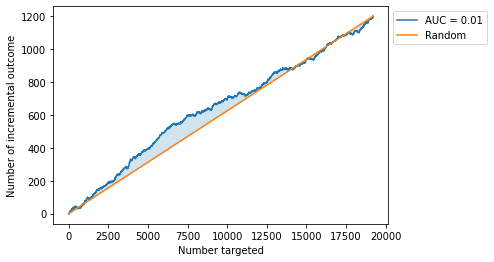

In [ ]:
from sklift.viz import plot_uplift_curve


# with ideal curve
# perfect=True
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=False); # perfect=True

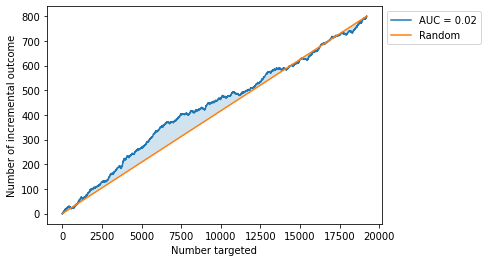

In [ ]:
from sklift.viz import plot_qini_curve


# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_val, uplift_sm, treat_val, perfect=False);

In [ ]:
from sklift.metrics import qini_auc_score


# коэффициент qini, или area under qini curve (AUQC)
auqc = qini_auc_score(y_val, uplift_sm, treat_val) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.0180


In [ ]:
from sklift.metrics import uplift_by_percentile

# uplift by decile, или  uplift by percentile, или uplift by bin.
uplift_by_percentile(y_val, uplift_sm,  treat_val, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1309,611,0.220015,0.144026,0.075989,0.011450,0.014205,0.018245
10-20,1280,640,0.206250,0.120313,0.085937,0.011309,0.012860,0.017125
20-30,1315,605,0.180989,0.092562,0.088427,0.010617,0.011783,0.015861
30-40,1280,640,0.155469,0.095312,0.060156,0.010128,0.011607,0.015405
40-50,1237,683,0.163298,0.121523,0.041776,0.010510,0.012502,0.016333
50-60,1275,645,0.134902,0.103876,0.031026,0.009567,0.012013,0.015357
60-70,1268,652,0.153785,0.084356,0.069430,0.010131,0.010884,0.014869
70-80,1260,660,0.121429,0.087879,0.033550,0.009202,0.011020,0.014357
80-90,1278,642,0.148670,0.074766,0.073903,0.009952,0.010380,0.014380


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


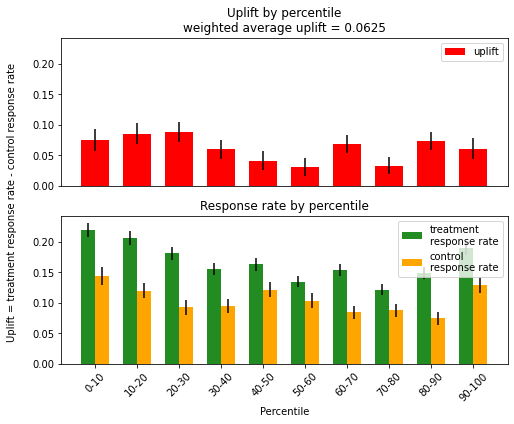

In [ ]:
from sklift.viz import plot_uplift_by_percentile

# график uplift by percentile
plot_uplift_by_percentile(y_val, uplift_sm, treat_val, 
                          strategy='overall', kind='bar'); # line

In [ ]:
from sklift.metrics import weighted_average_uplift

# с помощью значений в столбцах uplift и n_treatment рассчитаем усредненный uplift на всей выборке, 
# взвешенный на размер целевой группы — weighted average uplift
uplift_full_data = weighted_average_uplift(y_val, uplift_sm, 
                                            treat_val, bins=10) 
print(f"weighted average uplift on full data: {uplift_full_data:.4f}")

weighted average uplift on full data: 0.0623


In [ ]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,17.137378
1,is_referral,16.217929
2,recency,14.342947
3,history,13.572393
4,used_bogo,10.220216
5,used_discount,8.930307
6,channel_Phone,5.494874
7,zip_code_Rural,5.363769
8,channel_Web,3.673010
9,zip_code_Surburban,2.691685


In [ ]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['uplift@20%'].append(ct_score)

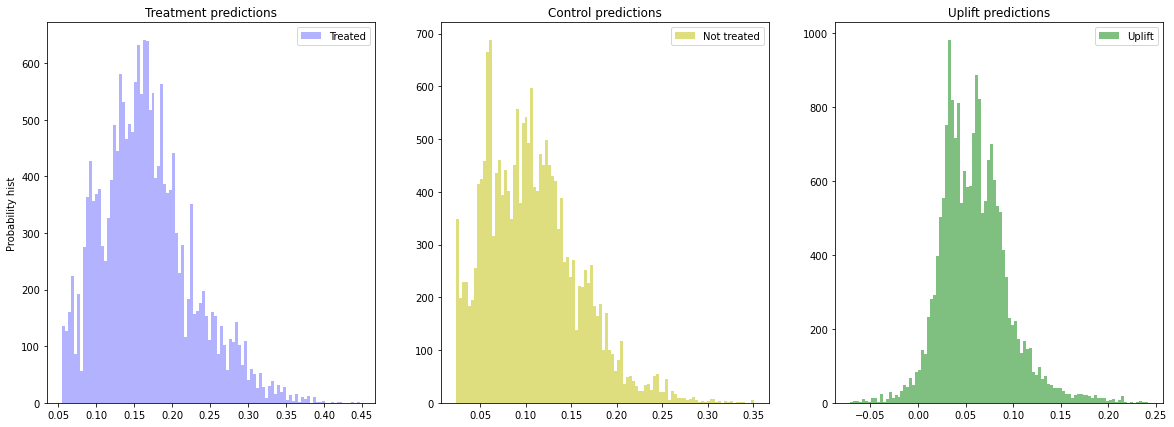

In [ ]:
from sklift.models import TwoModels


tm = TwoModels(  
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)   

# method ='ddr_control' ('ddr_treatment') - зависимые модели
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['uplift@20%'].append(tm_score)

plot_uplift_preds_(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

,approach,uplift@10%,uplift@20%
2,TwoModels,0.093931,0.081724
1,ClassTransformation,0.080660,0.079387
0,SoloModel,0.079861,0.079379


Solo Model


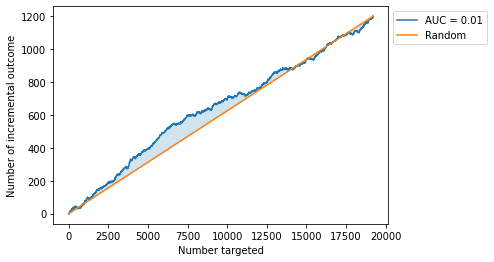

Two Model


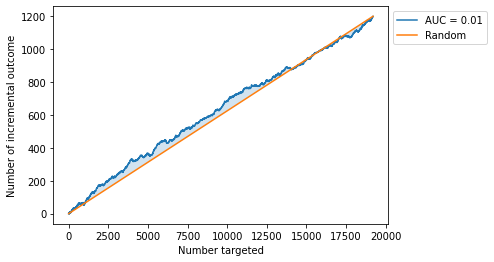

ClassTransform Model


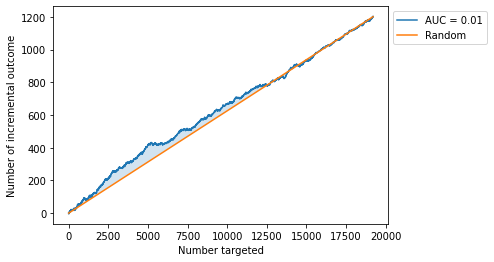

In [ ]:
print('Solo Model')

plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=False)
plt.show()
print('Two Model')
plot_uplift_curve(y_val, uplift_tm, treat_val, perfect=False)
plt.show()
print('ClassTransform Model')
plot_uplift_curve(y_val, uplift_ct, treat_val, perfect=False)
plt.show()

In [ ]:
X_train_tree = pd.concat([X_train.drop('recency', 1), 
                          pd.get_dummies(X_train['recency'], prefix='recency')], 1)
X_val_tree = pd.concat([X_val.drop('recency', 1), 
                          pd.get_dummies(X_val['recency'], prefix='recency')], 1)
features = [col for col in X_train_tree]

In [ ]:
!pip install causalml

     |████████████████████████████████| 243 kB 4.2 MB/s 
     |████████████████████████████████| 326 kB 43.3 MB/s 
     |████████████████████████████████| 1.8 MB 35.8 MB/s 
     |████████████████████████████████| 678 kB 49.8 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=495938 sha256=243daa4d6edd8589d3b8fe87ba433d6683eb467c7eb7c02100b9acda3f15b78f
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465075 sha256=180e5b6e3d32cb6358fa7b83f51ac8e9f018ed9ca6c8d15e10655c753a075b96
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


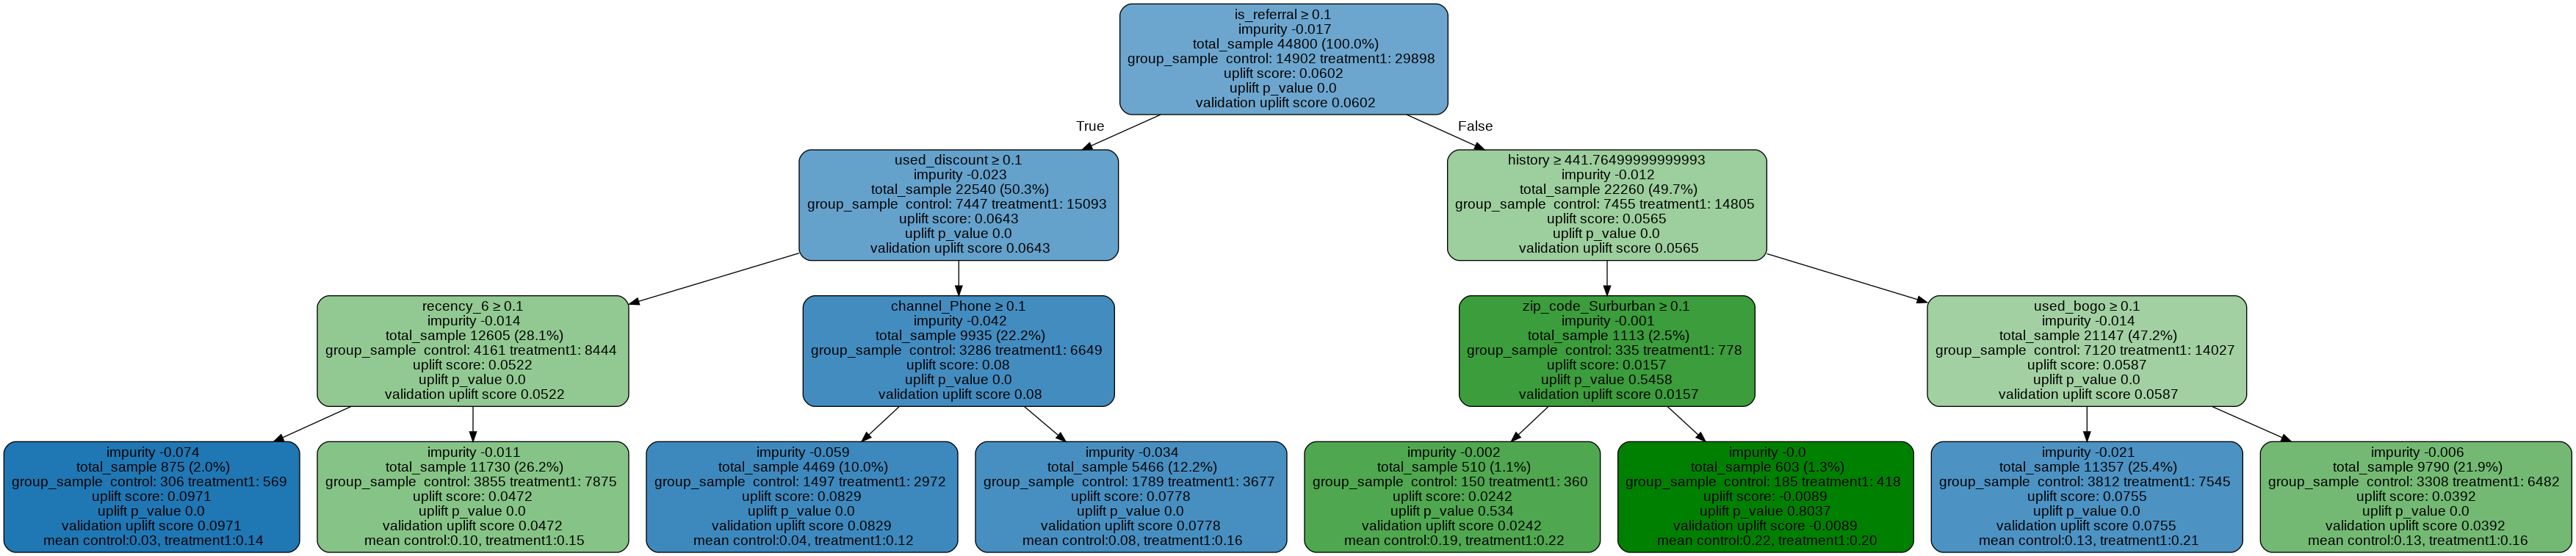

CPU times: user 4.57 s, sys: 397 ms, total: 4.97 s
Wall time: 8.09 s


In [ ]:
%%time
from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))